In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [45]:
df = pd.read_csv("team_traditional.csv")
df = df[df["season"] >= 2024].reset_index(drop=True)

# Keep base columns
df = df[[
    "gameid", "date", "team", "home", "away",
    "PTS", "FGM", "FGA", "FG%", "3PM", "3PA", "3P%",
    "FTM", "FTA", "FT%", "OREB", "DREB", "REB",
    "AST", "TOV", "STL", "BLK", "PF"
]].copy()

# Home flag
df["is_home"] = (df["team"] == df["home"]).astype(int)

# Split home vs away
home = df[df["is_home"] == 1].copy()
away = df[df["is_home"] == 0].copy()

# Merge into one row per game
games = home.merge(away, on="gameid", suffixes=("_home", "_away"))

# Rename for clarity
games = games.rename(columns={
    "team_home": "home_team",
    "team_away": "away_team",
    "PTS_home": "home_PTS",
    "PTS_away": "away_PTS"
})

# Date + sorting
games["date"] = pd.to_datetime(games["date_home"])
games = games.sort_values("date")

# True Shooting %
games["TS_home"] = games["home_PTS"] / (
    2 * (games["FGA_home"] + 0.44 * games["FTA_home"])
)
games["TS_away"] = games["away_PTS"] / (
    2 * (games["FGA_away"] + 0.44 * games["FTA_away"])
)

# Fix inf / NaN
games["TS_home"].replace([np.inf, -np.inf], np.nan, inplace=True)
games["TS_away"].replace([np.inf, -np.inf], np.nan, inplace=True)
games["TS_home"].fillna(games["TS_home"].mean(), inplace=True)
games["TS_away"].fillna(games["TS_away"].mean(), inplace=True)

# Target variable
games["TOTAL_POINTS"] = games["home_PTS"] + games["away_PTS"]

# Label encode categorical variables
le_home = LabelEncoder()
le_away = LabelEncoder()

games["home_team_enc"] = le_home.fit_transform(games["home_team"])
games["away_team_enc"] = le_away.fit_transform(games["away_team"])

# FINAL FEATURE SET
final_df = games[[
    "gameid", "date",

    # Encoded teams
    "home_team_enc", 
    "away_team_enc",

    # Shooting efficiency & pace
    "TS_home", "TS_away",
    "FGA_home", "FGA_away",

    # Possession/control
    "REB_home", "REB_away",
    "AST_home", "AST_away",
    "TOV_home", "TOV_away",

    # Target
    "home_PTS", "away_PTS",
    "TOTAL_POINTS"
]]

final_df.head(), final_df.shape

(      gameid       date  home_team_enc  away_team_enc   TS_home   TS_away  \
 0   22300061 2023-10-24              7             13  0.617989  0.541498   
 1   22300062 2023-10-24              9             23  0.458878  0.526932   
 13  22300074 2023-10-25             12             24  0.633759  0.552349   
 12  22300073 2023-10-25             26              6  0.602959  0.577346   
 11  22300072 2023-10-25             28             25  0.544725  0.586643   
 
     FGA_home  FGA_away  REB_home  REB_away  AST_home  AST_away  TOV_home  \
 0       91.0      90.0      42.0      44.0      29.0      23.0      12.0   
 1      101.0      95.0      49.0      60.0      19.0      23.0      11.0   
 13      90.0      93.0      45.0      40.0      36.0      20.0      18.0   
 12      89.0      99.0      45.0      48.0      33.0      24.0      19.0   
 11      91.0     102.0      54.0      45.0      22.0      29.0      14.0   
 
     TOV_away  home_PTS  away_PTS  TOTAL_POINTS  
 0       12.0   

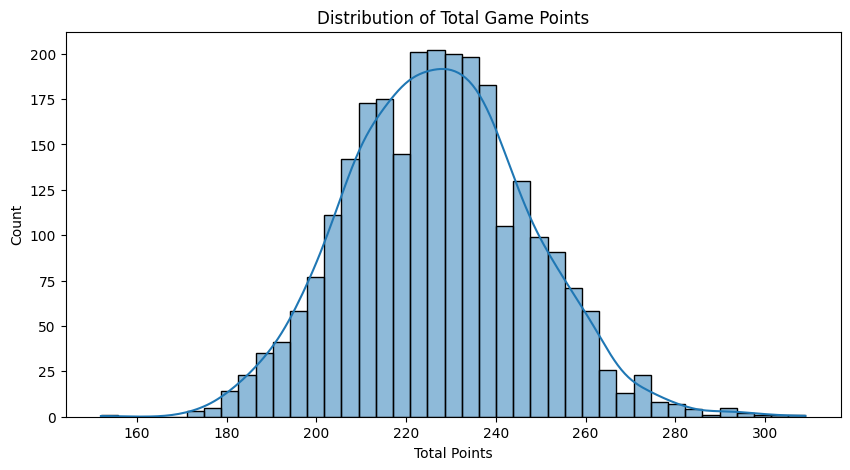

In [46]:
plt.figure(figsize=(10,5))
sns.histplot(final_df["TOTAL_POINTS"], kde=True)
plt.title("Distribution of Total Game Points")
plt.xlabel("Total Points")
plt.show()

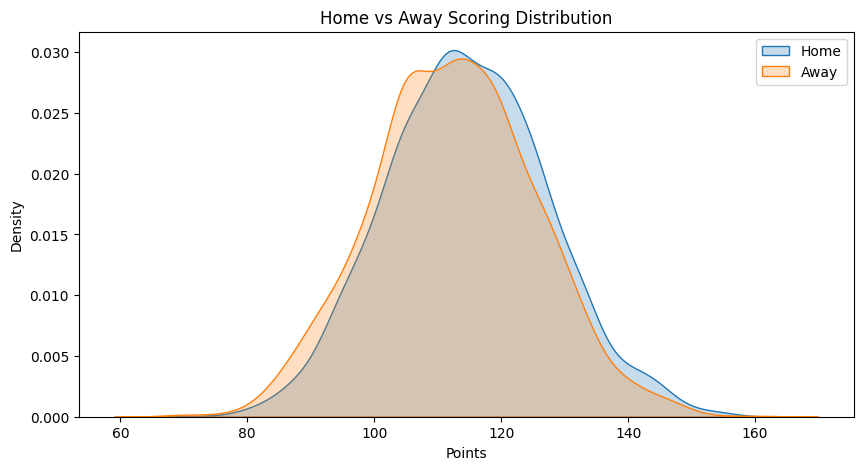

In [47]:
plt.figure(figsize=(10,5))
sns.kdeplot(final_df["home_PTS"], label="Home", fill=True)
sns.kdeplot(final_df["away_PTS"], label="Away", fill=True)
plt.title("Home vs Away Scoring Distribution")
plt.xlabel("Points")
plt.legend()
plt.show()

In [48]:
numeric_df = final_df.select_dtypes(include=["int64", "float64"])
corr_matrix = numeric_df.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

threshold = 0.85
to_drop = [col for col in upper.columns if any(upper[col] > threshold)]

reduced_df = final_df.drop(columns=to_drop)

print("Dropped columns:", to_drop)
print("Remaining columns:", reduced_df.columns)

Dropped columns: []
Remaining columns: Index(['gameid', 'date', 'home_team_enc', 'away_team_enc', 'TS_home',
       'TS_away', 'FGA_home', 'FGA_away', 'REB_home', 'REB_away', 'AST_home',
       'AST_away', 'TOV_home', 'TOV_away', 'home_PTS', 'away_PTS',
       'TOTAL_POINTS'],
      dtype='object')


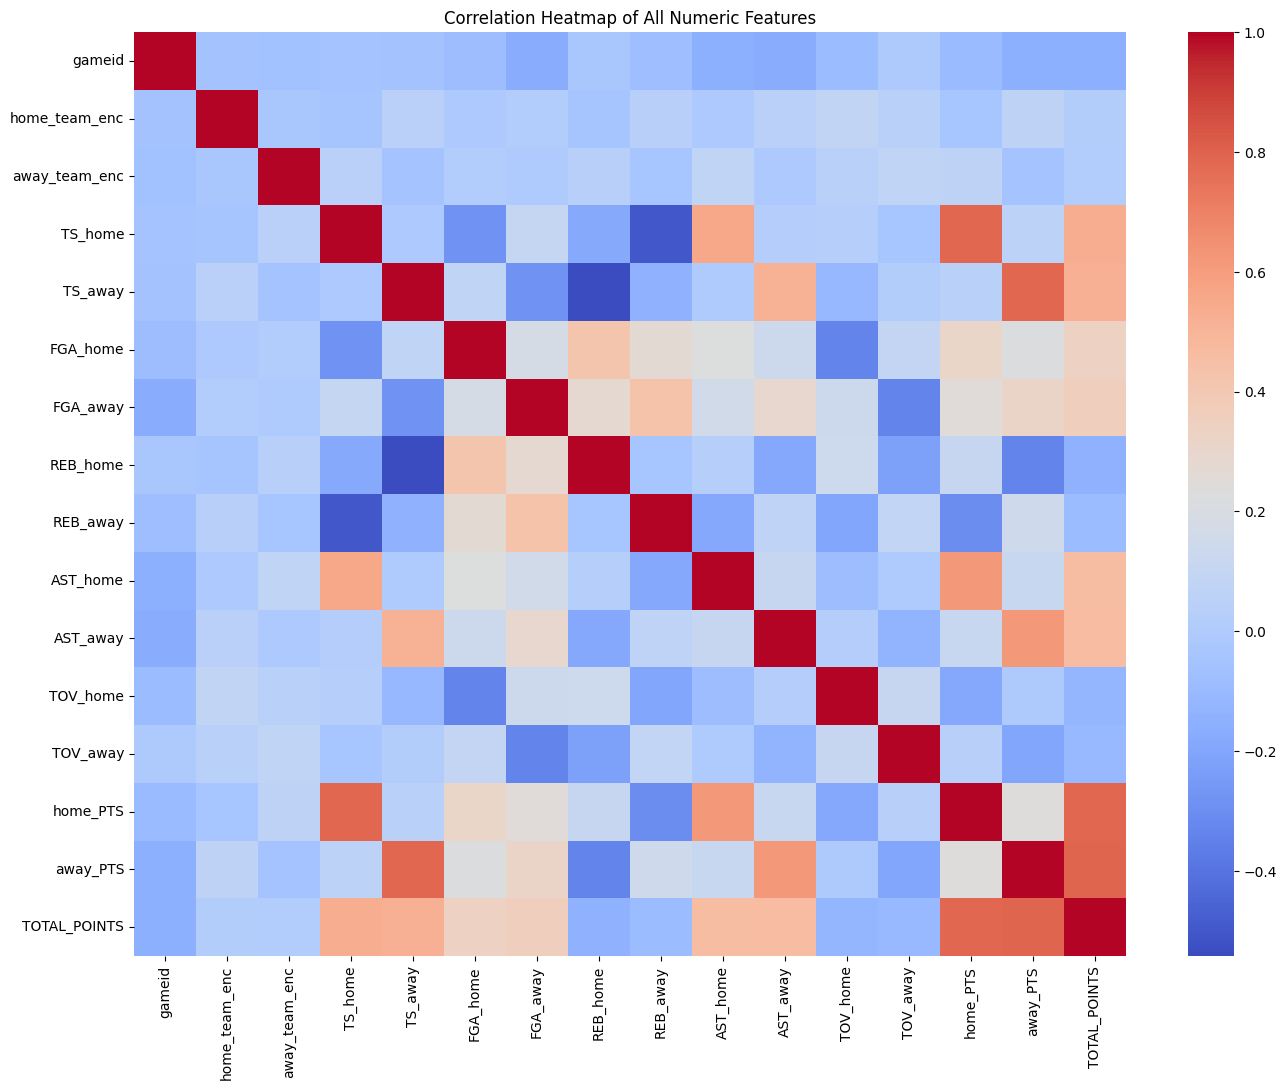

In [49]:
numeric_only = reduced_df.select_dtypes(include=["int64", "float64"])

plt.figure(figsize=(16, 12))
sns.heatmap(numeric_only.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of All Numeric Features")
plt.show()

In [50]:
from sklearn.model_selection import train_test_split

feature_cols = [
    "home_team_enc",
    "away_team_enc",
    "TS_home", "TS_away",
    "FGA_home", "FGA_away",
    "REB_home", "REB_away",
    "AST_home", "AST_away",
    "TOV_home", "TOV_away"
]

X = final_df[feature_cols]
y = final_df["TOTAL_POINTS"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=439
)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [51]:
import torch.nn as nn
import torch.optim as optim

# Convert data to torch tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create test_loader for validation
from torch.utils.data import DataLoader, TensorDataset
test_ds  = TensorDataset(X_test_t, y_test_t)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

input_dim = X_train_scaled.shape[1]

# DEFINE LAYERS
layer1 = nn.Linear(input_dim, 512)
layer2 = nn.Linear(512, 216)
layer3 = nn.Linear(216, 1)

relu = nn.ReLU()

# LOSS + OPTIMIZER (SGD)
criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.SGD(
    list(layer1.parameters()) +
    list(layer2.parameters()) +
    list(layer3.parameters()),
    lr=0.001,
    momentum=0.0
)

# FORWARD PASS
def forward(x):
    x = relu(layer1(x))
    x = relu(layer2(x))
    x = layer3(x)
    return x

# TRAINING LOOP
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    # ---- TRAIN ----
    optimizer.zero_grad()
    preds = forward(X_train_t)
    train_loss = criterion(preds, y_train_t)
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    # ---- VALIDATION ----
    val_loss_total = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = forward(xb)
            val_loss = criterion(preds, yb)
            val_loss_total += val_loss.item() * xb.size(0)

    val_loss = val_loss_total / len(test_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss.item():.4f} - Val Loss: {val_loss:.4f}")


Epoch 1/50 - Train Loss: 226.6090 - Val Loss: 226.5627
Epoch 2/50 - Train Loss: 226.6030 - Val Loss: 226.5566
Epoch 3/50 - Train Loss: 226.5969 - Val Loss: 226.5505
Epoch 4/50 - Train Loss: 226.5909 - Val Loss: 226.5445
Epoch 5/50 - Train Loss: 226.5848 - Val Loss: 226.5384
Epoch 6/50 - Train Loss: 226.5787 - Val Loss: 226.5323
Epoch 7/50 - Train Loss: 226.5726 - Val Loss: 226.5263
Epoch 8/50 - Train Loss: 226.5666 - Val Loss: 226.5202
Epoch 9/50 - Train Loss: 226.5605 - Val Loss: 226.5141
Epoch 10/50 - Train Loss: 226.5544 - Val Loss: 226.5080
Epoch 11/50 - Train Loss: 226.5483 - Val Loss: 226.5019
Epoch 12/50 - Train Loss: 226.5422 - Val Loss: 226.4958
Epoch 13/50 - Train Loss: 226.5361 - Val Loss: 226.4897
Epoch 14/50 - Train Loss: 226.5300 - Val Loss: 226.4836
Epoch 15/50 - Train Loss: 226.5238 - Val Loss: 226.4775
Epoch 16/50 - Train Loss: 226.5177 - Val Loss: 226.4714
Epoch 17/50 - Train Loss: 226.5116 - Val Loss: 226.4652
Epoch 18/50 - Train Loss: 226.5054 - Val Loss: 226.4591
E

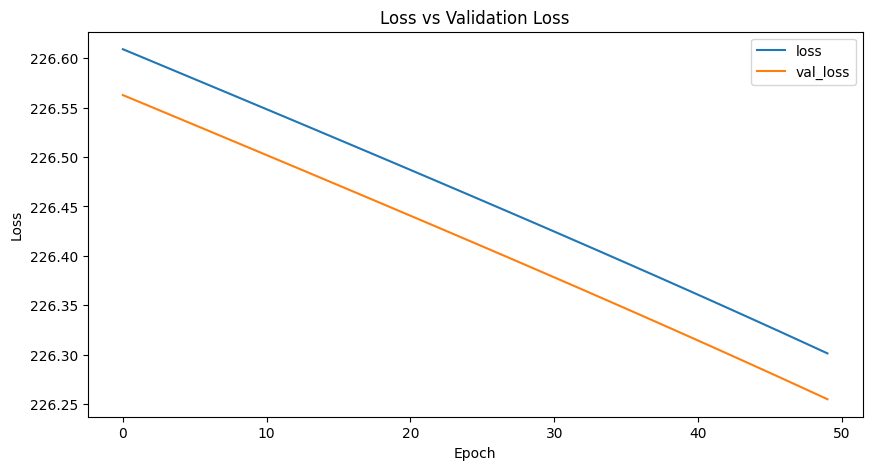

In [52]:
loss_df = pd.DataFrame({
    "loss": train_losses,
    "val_loss": val_losses
})

loss_df.plot(figsize=(10,5))
plt.title("Loss vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)

# Forward pass (no gradient)
with torch.no_grad():
    preds_t = forward(X_test_t)

# Convert back to numpy for sklearn
predictions = preds_t.numpy().flatten()


mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

MAE: 226.75501446580586
MSE: 51807.69780832003
RMSE: 227.61304402059218


In [54]:
print(predictions[:20])
print("Pred mean:", predictions.mean())
print("True mean:", y_test.mean())

[0.42451772 0.3716565  0.32311141 0.3443346  0.36398837 0.3579568
 0.34403574 0.34417346 0.3629118  0.32272968 0.33701593 0.33070773
 0.41543835 0.30381766 0.3506963  0.3767604  0.33716318 0.3390899
 0.3472503  0.3234987 ]
Pred mean: 0.36270705
True mean: 227.11772151898734
